In [4]:
SHUFFLE = True
BATCH_SIZE = 20
TEST_TRAIN = 0.2

KERNEL_SIZE = (100, 50, 25, 2, 2)
N_KERNELS = (10,20,40,80,160)
POOL_SIZE = (5,2,5,2)


DROPOUT = (0.1, 0.2, 0.25, 0.25, 0.8, 0.8)
DENSE_LEN = 20

In [5]:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, UpSampling2D, Dropout, BatchNormalization, Flatten, ELU
from keras.models import Model
from keras.models import load_model
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.initializers import Orthogonal as orth
from keras.callbacks import TensorBoard, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

# paths = ['/home/amplifier/home/DATASETS/BCI_0101T_TD.mat',
#          '/home/amplifier/home/DATASETS/BCI_0202T_TD.mat',
#         '/home/amplifier/home/DATASETS/BCI_0303T_TD.mat',
#         '/home/amplifier/home/DATASETS/BCI_0403T_TD.mat',
#         '/home/amplifier/home/DATASETS/BCI_0503T_TD.mat',
#         '/home/amplifier/home/DATASETS/BCI_0603T_TD.mat',
#         '/home/amplifier/home/DATASETS/BCI_0703T_TD.mat',
#         '/home/amplifier/home/DATASETS/BCI_0801T_TD.mat']

paths = ['/home/amplifier/home/DATASETS/Merged123->2-30Hz,Env=1_TD5_64_.mat',
         '/home/amplifier/home/DATASETS/Merged123->2-30Hz,Env=1_TD75_134_.mat',
         '/home/amplifier/home/DATASETS/Merged123->2-30Hz,Env=1_TD143_202_.mat',
         '/home/amplifier/home/DATASETS/Merged456->2-30Hz,Env=1_TD1_94_.mat',
         '/home/amplifier/home/DATASETS/Merged456->2-30Hz,Env=1_TD101_192_.mat',
         '/home/amplifier/home/DATASETS/Merged456->2-30Hz,Env=1_TD197_289_.mat']  

def load_file(file):
    print(file)
    mat_contents = sio.loadmat(file)
    X = mat_contents['X']
    Y = mat_contents['Z']

    if X.shape[1]<X.shape[2]:
        X = np.transpose(X,[0,2,1])

    if Y.shape[1] > Y.shape[0]:
        Y = Y.T

    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=TEST_TRAIN, shuffle=SHUFFLE)

    # convert to float64 for numerical stability:
    x_train = x_train.astype('float64')
    y_train = y_train.astype('float64')
    x_test = x_test.astype('float64')
    y_test = y_test.astype('float64')


    # one hot encode the labels:
    onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
    y_train = onehot_encoder.fit_transform(y_train)
    y_test = onehot_encoder.fit_transform(y_test)

    # convert to float16 to save space:
    x_train = x_train.astype('float16')
    y_train = y_train.astype('float16')
    x_test = x_test.astype('float16')
    y_test = y_test.astype('float16')

    leng = X.shape[1] # if you work in the FD, this is the height of the sample time-frequency image, othewise EEG channels
    chan = X.shape[2] # if you work in the FD, this is the width of the sample time-frequency image, othewise time samples of EEG signal

    if len(X.shape)==3:
        streams = 1 # this is EEG channels if you work with frequency domain, in the TD streams = 1
    if len(X.shape)==4:
        streams = X.shape[3] # this is EEG channels if you work with frequency domain, in the TD streams = 1
    
    return x_train, x_test, y_train, y_test, leng, chan, streams



def conv_net(leng):
    input_img = Input(shape=(leng, chan))  # adapt this if using `channels_first` image
    input_norm = BatchNormalization()(input_img)
    
    e2 = Conv1D(N_KERNELS[0], KERNEL_SIZE[0], padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(input_norm)
    e2act = ELU(alpha=1.0)(e2)
    e2p = MaxPooling1D(pool_size=POOL_SIZE[0], strides=None, padding='same')(e2act)
    e2b = BatchNormalization()(e2p)
    e2a = Dropout(DROPOUT[0])(e2b)
    
    
    e3 = Conv1D(N_KERNELS[1], KERNEL_SIZE[1], padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e2a)
    e3act = ELU(alpha=0.1)(e3)
    e4 = MaxPooling1D(pool_size=POOL_SIZE[1], strides=None, padding='same')(e3act)
    e4b = BatchNormalization()(e4)
    e4a = Dropout(DROPOUT[1])(e4b)
    
    
    e5 = Conv1D(N_KERNELS[2], KERNEL_SIZE[2], padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e4a)
    e5act = ELU(alpha=1.0)(e5)
    e6 = MaxPooling1D(pool_size=POOL_SIZE[2], strides=None, padding='same')(e5act)
    e6b = BatchNormalization()(e6)
    e6a = Dropout(DROPOUT[2])(e6b)
    
    
    e7 = Conv1D(N_KERNELS[3], KERNEL_SIZE[3], padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e6a)
    e7act = ELU(alpha=1.0)(e7)
    e8 = MaxPooling1D(pool_size=POOL_SIZE[3], strides=None, padding='same')(e7act)
    e8b = BatchNormalization()(e8)
    e9a = Dropout(DROPOUT[3])(e8b)
    
    
    e10 = Conv1D(N_KERNELS[4], KERNEL_SIZE[4], padding='same',
                                    kernel_initializer = orth(gain=1.0, seed=None))(e9a)
    e10act = ELU(alpha=1.0)(e10)
    e10b = BatchNormalization()(e10act)
    e10a = Dropout(DROPOUT[4])(e10b)
    
    
    e11 = Flatten()(e10a)
    
    e12 = Dense(DENSE_LEN, activation='sigmoid',
                                     kernel_initializer = orth(gain=1.0, seed=None))(e11)
    e12b = BatchNormalization()(e12)
    e12a = Dropout(DROPOUT[5])(e12b)

    e13 = Dense(2, activation='softmax')(e12a)

    return Model(input_img, e13)

In [ ]:
VAL_ACC = np.zeros([len(paths),5])

for file in range(len(paths)):
    for iter in range(5):
        x_train, x_test, y_train, y_test, leng, chan, streams = load_file(paths[file])
        print(paths[file], 'trial', iter)
        
        x = Input(shape=(chan, leng, streams))
        model = conv_net(leng)
        model.compile(loss='binary_crossentropy', optimizer='adadelta', metrics=['accuracy'])

        early_stopping = EarlyStopping(monitor='val_loss', patience=100, mode='min')
        checkpointer = ModelCheckpoint(filepath='/home/amplifier/home/NEW_DL/weights/EEGnet_weights_1D_mydat.h5',
                               verbose=1,
                               monitor='val_acc',
                               save_best_only=True)

        train_history = model.fit(x_train, y_train,
                        epochs=1000,
                        batch_size=BATCH_SIZE,
                        verbose=0,
                        shuffle=True,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpointer, early_stopping])
        
        model.load_weights('/home/amplifier/home/NEW_DL/weights/EEGnet_weights_1D_mydat.h5')
        decoded_train = model.predict(x_train)
        decoded_test = model.predict(x_test)

        

        cor_test = []
        L = x_test.shape
        for sample_no in range(x_test.shape[0]):
            pred = model.predict(np.expand_dims(x_test[sample_no],0))
            if ((pred[0][0]<pred[0][1]) and (y_test[sample_no,0] < y_test[sample_no,1]) or
               ((pred[0][0]>pred[0][1]) & (y_test[sample_no,0] > y_test[sample_no,1]))):
                cor_test.append(1)
            else:
                cor_test.append(0)

        cor_train = []
        L = x_train.shape
        for sample_no in range(x_train.shape[0]):
            pred = model.predict(np.expand_dims(x_train[sample_no],0))
            if ((pred[0][0]<pred[0][1]) and (y_train[sample_no,0] < y_train[sample_no,1]) or
               ((pred[0][0]>pred[0][1]) and (y_train[sample_no,0] > y_train[sample_no,1]))):
                cor_train.append(1)
            else:
                cor_train.append(0)

        print('Accuracy on the test data:', np.mean(cor_test))
        print('Accuracy on the training data:', np.mean(cor_train))
        VAL_ACC[file,iter] = np.mean(cor_test)
    

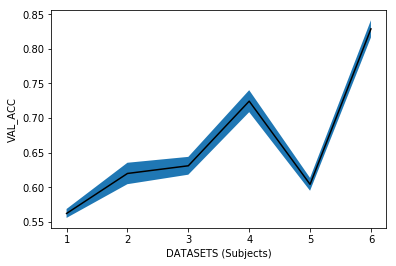

In [13]:
from scipy import stats

SE = stats.sem(VAL_ACC[:,:], axis=1)
M = np.mean(VAL_ACC[:,:], axis=1)

x = list(range(1,VAL_ACC.shape[0]+1))
plt.plot(x, M, 'k-')
plt.fill_between(x, M-SE, M+SE)
plt.xticks(x)
plt.xlabel('DATASETS (Subjects)')
plt.ylabel('VAL_ACC')
plt.show()

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        (None, 500, 60)           0         
_________________________________________________________________
batch_normalization_218 (Bat (None, 500, 60)           240       
_________________________________________________________________
conv1d_156 (Conv1D)          (None, 500, 10)           60010     
_________________________________________________________________
elu_156 (ELU)                (None, 500, 10)           0         
_________________________________________________________________
max_pooling1d_125 (MaxPoolin (None, 100, 10)           0         
_________________________________________________________________
batch_normalization_219 (Bat (None, 100, 10)           40        
_________________________________________________________________
dropout_187 (Dropout)        (None, 100, 10)           0         
__________